In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import PIL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Define file paths for training, testing, and validation CSV files
test_path = '/content/drive/MyDrive/DL/test_data.csv'
train_path = '/content/drive/MyDrive/DL/train_data.csv'
valid_path = '/content/drive/MyDrive/DL/valid_data.csv'


In [ ]:
# Load CSV files into DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
valid_df = pd.read_csv(valid_path)

In [ ]:
# Display tail of the training DataFrame
train_df.tail()

# Define fractions for train-test split
fractions = np.array([0.8, 0.1, 0.1])

# Shuffle the training data
train_df = train_df.sample(frac=1)

# Split the data into train, validation, and test sets
train_set, temp_set = train_test_split(train_df, test_size=fractions[1], random_state=42)
valid_set, test_set = train_test_split(temp_set, test_size=fractions[2], random_state=42)

In [ ]:
# Display lengths of the datasets
print("Training set length:", len(train_set))
print("Validation set length:", len(valid_set))
print("Test set length:", len(test_set))

# Display unique labels in the dataset
train_df.label.unique()


Training set length: 7210
Validation set length: 721
Test set length: 81


array([6, 4, 1, 2, 0, 3, 5])

In [ ]:
# Define classes
classes = {
    0: ('akiec', 'actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', 'basal cell carcinoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    3: ('df', 'dermatofibroma'),
    4: ('nv', 'melanocytic nevi'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    6: ('mel', 'melanoma'),
}


In [ ]:
# Extract features and labels for training set
y_train = train_set['label']
x_train = train_set.drop(columns=['label'])

# Extract features and labels for validation set
y_valid = valid_set['label']
x_valid = valid_set.drop(columns=['label'])

# Extract features and labels for test set
y_test = test_set['label']
x_test = test_set.drop(columns=['label'])

# Convert x_train, x_valid, and x_test to NumPy arrays
x_train = np.array(x_train, dtype=np.uint8).reshape(-1, 28, 28, 3)
x_valid = np.array(x_valid, dtype=np.uint8).reshape(-1, 28, 28, 3)
x_test = np.array(x_test, dtype=np.uint8).reshape(-1, 28, 28, 3)

# Reshape x_train to 2D array
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)

In [ ]:
# Resample the training set using RandomOverSampler to address class imbalance
oversample = RandomOverSampler()
x_train_resampled, y_train_resampled = oversample.fit_resample(x_train_reshaped, y_train)

# Reshape x_train_resampled back to 4D array
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 28, 28, 3)

In [ ]:
# Create a convolutional neural network model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7, activation='softmax'))

# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 14, 14, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)         

In [ ]:
# Define model callbacks
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model.h5',
                                              monitor='val_accuracy', mode='max',
                                              verbose=1, save_best_only=True)

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_valid, y_valid),
                    batch_size=128,
                    epochs=50,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/50
265/265 [==============================] - ETA: 0s - loss: 1.2117 - accuracy: 0.5518
Epoch 1: val_accuracy improved from -inf to 0.46047, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model.h5
265/265 [==============================] - 8s 13ms/step - loss: 1.2117 - accuracy: 0.5518 - val_loss: 1.3887 - val_accuracy: 0.4605
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


262/265 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8520
Epoch 2: val_accuracy improved from 0.46047 to 0.61165, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model.h5
265/265 [==============================] - 4s 14ms/step - loss: 0.4194 - accuracy: 0.8523 - val_loss: 1.0563 - val_accuracy: 0.6117
Epoch 3/50
261/265 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9099
Epoch 3: val_accuracy improved from 0.61165 to 0.65187, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model.h5
265/265 [==============================] - 3s 13ms/step - loss: 0.2476 - accuracy: 0.9098 - val_loss: 1.3491 - val_accuracy: 0.6519
Epoch 4/50
262/265 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9392
Epoch 4: val_accuracy improved from 0.65187 to 0.66713, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model.h5
265/265 [==============================] - 3s 11

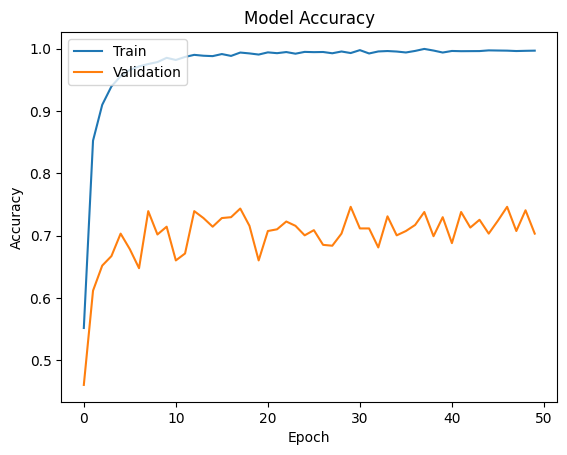

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the best model weights
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model.h5')

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

3/3 - 0s - loss: 1.2996 - accuracy: 0.7901 - 41ms/epoch - 14ms/step
Test Loss: 1.2996
Test Accuracy: 0.7901


In [ ]:
# Make predictions on a sample image
image = PIL.Image.open('/content/drive/MyDrive/Skin-Cancer-Classification/1234214.jpg')
image = image.resize((28, 28))
img = np.array(image).reshape(-1, 28, 28, 3)


FileNotFoundError: ignored

In [ ]:
# Make predictions
result = model.predict(img)
print(result[0])

# Convert predictions to a class index
result = result.argmax(axis=-1)[0]

# Print the predicted class
print(classes[result])

In [ ]:
# Generate confusion matrix and classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


3/3 [==============================] - 0s 4ms/step
Confusion Matrix:
[[ 0  2  1  1  0  0]
 [ 0  3  0  0  0  0]
 [ 1  0  1  6  0  0]
 [ 0  0  1 52  0  2]
 [ 0  0  0  0  2  0]
 [ 0  0  0  3  0  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.60      1.00      0.75         3
           2       0.33      0.12      0.18         8
           4       0.84      0.95      0.89        55
           5       1.00      1.00      1.00         2
           6       0.75      0.67      0.71         9

    accuracy                           0.79        81
   macro avg       0.59      0.62      0.59        81
weighted avg       0.73      0.79      0.75        81



Training set length: 7210
Validation set length: 721
Test set length: 81
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_48 (Ba  (None, 14, 14, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_41 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 conv2d_42 (Conv2D)          (None, 10, 10, 64)        18496     
                                               

Epoch 1/50
54/57 [===========================>..] - ETA: 0s - loss: 1.8476 - accuracy: 0.3989
Epoch 1: val_accuracy improved from -inf to 0.69071, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_CNN_nosamp.h5
57/57 [==============================] - 6s 18ms/step - loss: 1.8311 - accuracy: 0.4079 - val_loss: 1.2232 - val_accuracy: 0.6907
Epoch 2/50
 1/57 [..............................] - ETA: 0s - loss: 1.5470 - accuracy: 0.5547

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/57 [==========================>...] - ETA: 0s - loss: 1.2935 - accuracy: 0.6492
Epoch 2: val_accuracy did not improve from 0.69071
57/57 [==============================] - 1s 11ms/step - loss: 1.2836 - accuracy: 0.6534 - val_loss: 1.0562 - val_accuracy: 0.6865
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 1.0333 - accuracy: 0.7090
Epoch 3: val_accuracy improved from 0.69071 to 0.71012, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_CNN_nosamp.h5
57/57 [==============================] - 1s 13ms/step - loss: 1.0333 - accuracy: 0.7090 - val_loss: 0.8813 - val_accuracy: 0.7101
Epoch 4/50
57/57 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.7240
Epoch 4: val_accuracy did not improve from 0.71012
57/57 [==============================] - 1s 11ms/step - loss: 0.9006 - accuracy: 0.7240 - val_loss: 1.0845 - val_accuracy: 0.6865
Epoch 5/50
54/57 [===========================>..] - ETA: 0s - loss: 0.8102 - accuracy: 0.

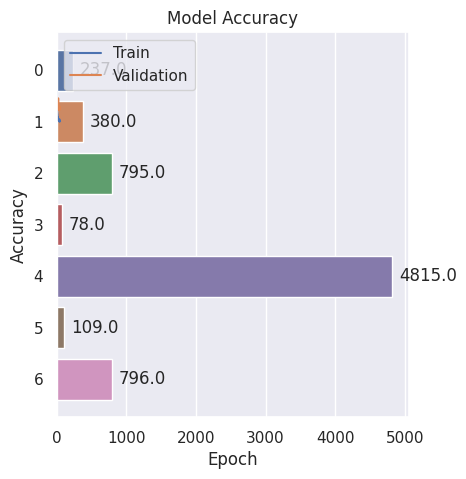

3/3 - 0s - loss: 1.9814 - accuracy: 0.7160 - 28ms/epoch - 9ms/step
Test Loss: 1.9814
Test Accuracy: 0.7160
3/3 [==============================] - 0s 6ms/step
Confusion Matrix:
[[ 0  0  1  0  0  0  2]
 [ 0  2  1  1  0  0  0]
 [ 0  0  3  0  3  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  3  0 50  0  4]
 [ 0  1  0  0  1  0  0]
 [ 0  0  2  0  3  0  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.50      0.57         4
           2       0.30      0.50      0.37         6
           3       0.00      0.00      0.00         1
           4       0.86      0.88      0.87        57
           5       0.00      0.00      0.00         2
           6       0.33      0.38      0.35         8

    accuracy                           0.72        81
   macro avg       0.31      0.32      0.31        81
weighted avg       0.69      0.72      0.70        81



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define file paths for training, testing, and validation CSV files
test_path = '/content/drive/MyDrive/DL/test_data.csv'
train_path = '/content/drive/MyDrive/DL/train_data.csv'
valid_path = '/content/drive/MyDrive/DL/valid_data.csv'

# Load CSV files into DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
valid_df = pd.read_csv(valid_path)

# Display tail of the training DataFrame
train_df.tail()

# Define fractions for train-test split
fractions = np.array([0.8, 0.1, 0.1])

# Shuffle the training data
train_df = train_df.sample(frac=1)

# Split the data into train, validation, and test sets
train_set, temp_set = train_test_split(train_df, test_size=fractions[1], random_state=42)
valid_set, test_set = train_test_split(temp_set, test_size=fractions[2], random_state=42)

# Display lengths of the datasets
print("Training set length:", len(train_set))
print("Validation set length:", len(valid_set))
print("Test set length:", len(test_set))

# Display unique labels in the dataset
train_df.label.unique()

# Define classes
classes = {
    0: ('akiec', 'actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', 'basal cell carcinoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    3: ('df', 'dermatofibroma'),
    4: ('nv', 'melanocytic nevi'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    6: ('mel', 'melanoma'),
}

# Extract features and labels for training set
y_train = train_set['label']
x_train = train_set.drop(columns=['label'])

# Extract features and labels for validation set
y_valid = valid_set['label']
x_valid = valid_set.drop(columns=['label'])

# Extract features and labels for test set
y_test = test_set['label']
x_test = test_set.drop(columns=['label'])

# Convert x_train, x_valid, and x_test to NumPy arrays
x_train = np.array(x_train, dtype=np.uint8).reshape(-1, 28, 28, 3)
x_valid = np.array(x_valid, dtype=np.uint8).reshape(-1, 28, 28, 3)
x_test = np.array(x_test, dtype=np.uint8).reshape(-1, 28, 28, 3)

# Countplot for better visibility of class distribution in the training set before undersampling
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(y=y_train)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.title('Class Distribution Before Undersampling')

# Create a convolutional neural network model
# Create a convolutional neural network model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7, activation='softmax'))

# Display the model summary
model.summary()

# Define model callbacks
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_CNN_nosamp.h5',
                                              monitor='val_accuracy', mode='max',
                                              verbose=1, save_best_only=True)

# Compile the model
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model

history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    batch_size=128,
                    epochs=50,
                    shuffle=True,
                    callbacks=[callback])

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()






# Load the best model weights
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_CNN_nosamp.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


# Generate confusion matrix and classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


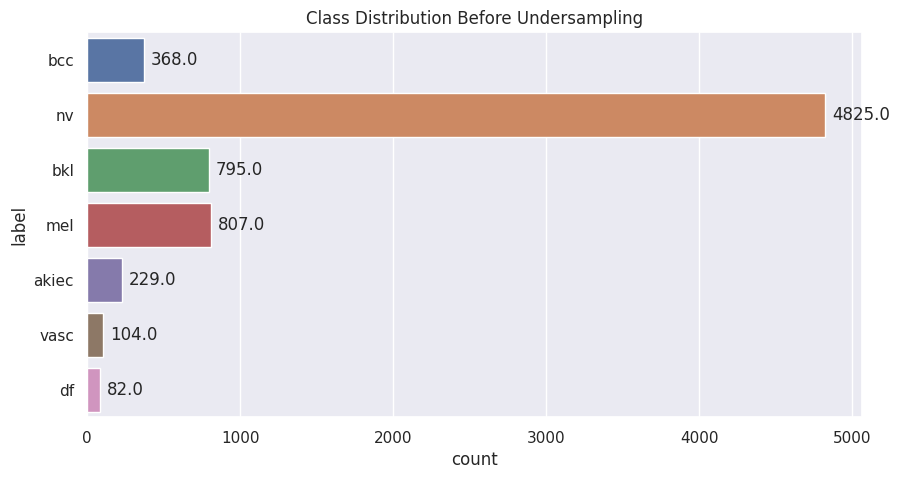

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map numeric labels to class names
class_names = [classes[i][0] for i in range(len(classes))]
y_train_names = y_train.map({i: class_names[i] for i in range(len(class_names))})

# Set the style for better visibility
sns.set(style="darkgrid")

# Create the count plot with annotations
plt.figure(figsize=(10, 5))  # Set the figure size for better visualization
ax = sns.countplot(y=y_train_names)

# Add annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.title('Class Distribution Before Undersampling')  # Add a title to the plot
plt.show()  # Display the plot
